In [1]:
import utils
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import torch
import torchvision.models as models
import torch.nn as nn
import dataset_loading
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import net
import copy
from torchvision import transforms
%load_ext autoreload
%autoreload 2

from configparser import ConfigParser

config = ConfigParser()
config.read("../yoloconfig.cfg")

INPUT_SIZE = int(config['DEFAULT']['input_size'])
classes = config['DEFAULT']['classes'].split(",")
S = int(config['DEFAULT']['num_cells'])
B = int(config['DEFAULT']['num_bboxes'])
C = len(classes)
class_dict = {cls: i for i, cls in enumerate(classes)}
datadir_train = config['DEFAULT']['datadir_train']
datadir_test = config['DEFAULT']['datadir_test']

In [2]:
model = models.vgg11(pretrained=True)
model = net.YOLOModel(model, only_fc=True)
model = model.cuda()

In [ ]:
model

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.04),
    #transforms.RandomRotation(degrees=2), #just a small one shouldnt affect bbox locations
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

cls = '' #add _ to end if using class
datasets = {}
datasets['train'] = dataset_loading.VOCDetection(datadir_train, 
                                  cls + 'train', 
                                  transform=train_transform,
                                  target_transform=dataset_loading.TransformYOLOTrainVal(False))

datasets['val'] = dataset_loading.VOCDetection(datadir_train, 
                                  cls + 'val', 
                                  transform=val_transform,
                                  target_transform=dataset_loading.TransformYOLOTrainVal(False))

datasets['test'] = dataset_loading.VOCDetection(datadir_test, 
                                  cls + 'test', 
                                  transform=val_transform,
                                  target_transform=dataset_loading.TransformYOLOTest(False))

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

In [66]:
dataset_sizes

{'test': 4952, 'train': 2501, 'val': 2510}

In [4]:
mse = nn.MSELoss()
lambda_coord = 5
lambda_noobj = 0.5
batch_size = 16
epochs = 30
use_gpu = True
shuffle=True
lr = 0.00001
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)

def lr_schedule(epoch):
    if epoch > 100:
        return 1
    
    if epoch > 30:
        return 10
    
    if epoch > 5:
        return 10 * (epoch / 30)
    
    return 1

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

if use_gpu:
    model = model.cuda()

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                             shuffle=shuffle, num_workers=4)
              for x in ['train', 'val', 'test']}

In [5]:
param = {}
param['best_val_res'] = np.inf
param['optimizer'] = optimizer
param['scheduler'] = scheduler

In [ ]:
def lr_schedule(epoch):
    return 10

new_sched = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

In [7]:
param = net.train_model(model, param['optimizer'], mse, lambda_coord, lambda_noobj, 
                        batch_size, dataloaders, param['best_val_res'], 50, scheduler=None)

1e-05
Running epoch loss (training):  25392.46880722046
New best model found
Val loss:  21852.135719299316
1e-05
Running epoch loss (training):  15603.017059326172
1e-05
Running epoch loss (training):  10516.475994110107
1e-05
Running epoch loss (training):  8031.431125640869
1e-05
Running epoch loss (training):  6476.7996616363525
1e-05
Running epoch loss (training):  5558.424118041992
New best model found
Val loss:  13591.125606536865
1e-05
Running epoch loss (training):  4683.436932563782
1e-05
Running epoch loss (training):  4201.828767776489
1e-05
Running epoch loss (training):  3724.1897926330566
1e-05
Running epoch loss (training):  3360.430826187134
1e-05
Running epoch loss (training):  3158.2245292663574
New best model found
Val loss:  12976.470909118652
1e-05
Running epoch loss (training):  2958.141390800476
1e-05
Running epoch loss (training):  2906.636646747589
1e-05
Running epoch loss (training):  2706.1240100860596
1e-05
Running epoch loss (training):  2499.9715213775635


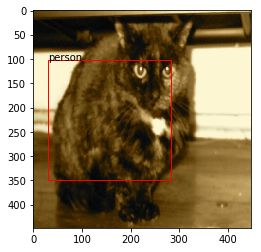

In [71]:
img, labels = datasets['val'][545]
model.train(False)
test = model(Variable(img.unsqueeze(0).cuda()))
test = test.view(S, S, C + B*5)
res = utils.interpret_yolo(test.cpu().data.numpy(), 0.05)
bb = np.array([np.append(x['bbox'], x['confidence']) for x in res])
nmsed = utils.py_cpu_nms(bb, 0.4)
noice = [(x['bbox'], x['class_name']) for x in res]
noice = [noice[i] for i in nmsed]
utils.plot_img(img, noice)

In [ ]:
res #when theres a person in the image it seems it predicts all as person, maybe prertained sends
# this kind of data whenever theres a person somewhere in the image? maybe whole network needs to be trained
#instead of just fcc?

In [ ]:
test[3,3,:20]

In [ ]:
bb = np.array([np.append(x['bbox'], x['score']) for x in res])
nmsed = utils.py_cpu_nms(bb, 0.5)
noice[nmsed]

In [ ]:
def test_results(model, testset):
    results = []
    for inputs, labels, img_id in testset:
        if use_gpu:
            inputs = Variable(inputs.cuda().unsqueeze(0))
        else:
            inputs = Variable(inputs)
        
        output = model(inputs)
        output = output.view(S, S, C + B*5)
        
        
        res = utils.interpret_yolo(output.cpu().data.numpy(), 0.4)
        for r in res: r['img_id'] = img_id
        results.append(res)
        
    return results
        
    
results = test_results(model, datasets['test'])

In [ ]:
utils.save_results(results)

In [ ]:
flat_results = [item for items in results for item in items]

In [ ]:
import voc_eval

root = "/home/tman/koulu/Deep Learning/project/"
detpath = root + "results/"
annopath = root + "datasets/VOC2007Test/VOCdevkit/VOC2007/Annotations/dog_test.txt"
imagesetfile = root + "datasets/VOC2007Test/VOCdevkit/VOC2007/ImageSets/Main/dog_test.txt"

eva = voc_eval.voc_eval(detpath, annopath, imagesetfile, 'dog', root + "cache")